Parallel : spatial + channel
Note: cannot call this cbam (as cbam is for sequential)

In [ ]:
import numpy as np
import cv2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Load the dataset
!unzip /content/drive/MyDrive/sammTEST2.zip -d '/content/SAMM'

Archive:  /content/drive/MyDrive/sammTEST2.zip
   creating: /content/SAMM/sammTEST2/Anger/
  inflating: /content/SAMM/sammTEST2/Anger/006_5_11_frame96.png  
  inflating: /content/SAMM/sammTEST2/Anger/006_5_11_frame97.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame1.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame10.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame11.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame12.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame13.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame14.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame15.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame16.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame17.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame18.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame19.png  
  inflating: /content/SAMM/sammTEST2/Anger/009_3_2_frame2.png  

In [ ]:
# Define the transformations to apply to each image (for both train and test)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Resizing for VGG16 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Custom Dataset class
class MicroExpressionDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Populate image_paths and labels lists
        for class_idx, class_name in enumerate(os.listdir(image_dir)):
            class_dir = os.path.join(image_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_to_idx[class_name] = class_idx
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        image = cv2.resize(image, (256, 256))

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Initialize dataset
root_dir = '/content/SAMM/sammTEST2'
dataset = MicroExpressionDataset(image_dir=root_dir, transform=transform)

torch.Size([32, 3, 256, 256])
torch.Size([32])


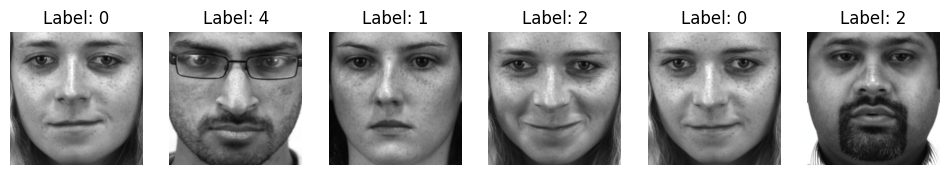

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import numpy as np

# Define mean and std for unnormalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Fetch a batch
images, labels = next(iter(dataloader))
print(images.shape)
print(labels.shape)

# Convert images to numpy and plot
fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for i in range(6):
    img = images[i].permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")
plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split

# Assuming 'dataset' is your complete dataset
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = int(0.1 * total_size)   # 10% for validation
test_size = total_size - train_size - val_size  # 10% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Print the number of batches in each DataLoader
print(f'Number of training batches: {len(train_loader)}')
print(f'Number of validation batches: {len(val_loader)}')
print(f'Number of testing batches: {len(test_loader)}')

# Checking the output shape and class labels for training set
for images, labels in train_loader:
    print(f'Training batch - Image batch dimensions: {images.shape}')  # Expected: torch.Size([16, 3, 256, 256])
    print(f'Training batch - Label batch dimensions: {labels.shape}')  # Expected: torch.Size([16])
    break  # Stop after first iteration to check for errors

# Checking the output shape and class labels for validation set
for images, labels in val_loader:
    print(f'Validation batch - Image batch dimensions: {images.shape}')  # Expected: torch.Size([16, 3, 256, 256])
    print(f'Validation batch - Label batch dimensions: {labels.shape}')  # Expected: torch.Size([16])
    break  # Stop after first iteration to check for errors

# Checking the output shape and class labels for testing set
for images, labels in test_loader:
    print(f'Testing batch - Image batch dimensions: {images.shape}')  # Expected: torch.Size([16, 3, 256, 256])
    print(f'Testing batch - Label batch dimensions: {labels.shape}')  # Expected: torch.Size([16])
    break  # Stop after first iteration to check for errors


Number of training batches: 159
Number of validation batches: 20
Number of testing batches: 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training batch - Image batch dimensions: torch.Size([16, 3, 256, 256])
Training batch - Label batch dimensions: torch.Size([16])
Validation batch - Image batch dimensions: torch.Size([16, 3, 256, 256])
Validation batch - Label batch dimensions: torch.Size([16])
Testing batch - Image batch dimensions: torch.Size([16, 3, 256, 256])
Testing batch - Label batch dimensions: torch.Size([16])


In [ ]:
image, label = val_dataset[0]
print(f"Val Image shape: {image.shape}, Label: {label}")  # Should be (3, 256, 256)
print(f"Val Image mean: {image.mean()}, std: {image.std()}") # Should be ~0 mean, ~1 std after Normalize()
# Manually Check an Image on val_set to see if it is normalised

Val Image shape: torch.Size([3, 256, 256]), Label: 1
Val Image mean: 0.08561723679304123, std: 0.7173977494239807


In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio):
        super(ChannelAttention, self).__init__()

        # Adaptive average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # Adaptive max pooling
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Convolution layers for channel reduction
        self.conv1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False)
        self.relu = nn.ReLU()

        # Final convolution to restore original channel size
        self.conv2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)

        # Sigmoid for attention weights
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply global average pooling and max pooling
        avg_out = self.conv1(self.avg_pool(x))
        max_out = self.conv1(self.max_pool(x))

        # Combine the outputs of both pooling methods (you can add or concatenate)
        out = self.relu(avg_out + max_out)  # Element-wise addition of avg and max outputs

        # Restore the original channel size and apply sigmoid activation
        out = self.conv2(out)

        # print(out.shape , 'CA')
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        # 7x7 Convolution layer
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply average pooling across the channel dimension (dim=1)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        # print(avg_out.shape , 'jasssssi avg')

        # Apply max pooling across the channel dimension (dim=1)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        # print(max_out.shape , 'jasssssi max')

        # Concatenate along the channel dimension
        out = torch.cat([avg_out, max_out], dim=1)
        # print(out.shape , 'SA')

        # Apply convolution and sigmoid activation
        out = self.conv(out)
        return self.sigmoid(out)

In [ ]:
import torch
import torch.nn as nn

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8, kernel_size=3):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_channels=in_channels, reduction_ratio=reduction_ratio)  # Channel Attention
        self.sa = SpatialAttention(kernel_size=kernel_size)  # Spatial Attention

    def forward(self, x):
        original = x  # Store original input for residual connection

        # Apply Channel Attention and Spatial Attention independently
        ca_out = self.ca(x)  # Channel Attention Output
        sa_out = self.sa(x)  # Spatial Attention Output

        # Element-wise multiplication of input with both attention outputs
        x_ca = x * ca_out
        x_sa = x * sa_out

        # Residual Connection
        refine = x_ca + x_sa + original

        # print(refine.shape , 'cbam')
        return x

In [ ]:
class CNNWithCBAMmodel(nn.Module):
    def __init__(self):
        super(CNNWithCBAMmodel, self).__init__()

        # First Conv Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

         # Second Conv Layer
        self.conv2_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1) # Channel 8 to 16
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adding CBAM layer for channels 8 -> 16
        self.cbam1 = CBAM(in_channels=16)


         # Third Conv Layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1) # Channel 8 to 16
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Fourth Conv Layer
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        # self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layer (optional: choose dropout probability, e.g., 0.2 means 50% of neurons will be dropped)
        self.dropout = nn.Dropout(0.2)

        # Fully Connected Layer
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        #After the 4th convo. (self.conv4), there are 64 o/p ch.
        #Each time you apply max pooling (self.pool), the spatial size of the image is halved.
        #image size of 256x256; after 1st pooling : 128x128; after 2nd 64x64; after 3rd 32x32, 16 *16
        #512 is design choice; 64 * 16 *16 = 65536 :You are reducing the 65536 input features into 512
        #features, which is common to reduce the dimensionality & retaining imp info for classification.
        #self.fc2 = nn.Linear(4096,2048)
        #self.fc3 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 6)  # 6 output classes (assuming classification into 6 classes)

    def forward(self, x):
        # First Conv Layer with ReLU and MaxPooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # print(x.shape, 'jass1')

        x = F.relu(self.conv2_1(x))
        x = self.pool(x)
        # print(x.shape, 'jass2')

        x = self.cbam1(x)
        # print(x.shape, 'jasscbam')

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        # print(x.shape, 'jass3')

        # print(x.shape, 'jasssii ko attention do 32 baar')
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        # print(x.shape, 'jasssiiii paaaaji 64 baar')


        # Flatten the output
        x = x.view(-1, 16 *16 * 64)  # Flattening to pass into fully connected layers
        # print(x.shape, 'jasssiiii paaaaji yy baar')

        # Fully connected layers with ReLU and softmax output
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # print(x.shape, 'jasssiiii paaaaji yy baar')

        x = F.softmax(self.fc2(x), dim=1)  # For multi-class classification

        # print(x.shape , 'cbam + cnn')
        return x

# Create the model instance
model = CNNWithCBAMmodel()

# Print the model summary
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Equivalent to 'categorical_crossentropy' in Keras
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4) #L2 Regularization (weight decay)

CNNWithCBAMmodel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
  (cbam1): CBAM(
    (ca): ChannelAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (conv1): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU()
      (conv2): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (sigmoid): Sigmoid()
    )
    (sa): SpatialAttention(
      (conv): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (sigmoid): Sigmoid()
    )
  )
  (conv3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2)

In [ ]:
# Training the model
num_epochs = 25

for epoch in range( num_epochs):  # 10 epochs
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    num_batches = len(train_loader)
    print(len(train_loader))

    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        # print(outputs.shape, 'jasssssiiiiii')
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
        total += labels.size(0)  # Total number of examples
        correct += (predicted == labels).sum().item()  # Count correct predictions

        # Calculate accuracy for this batch
        batch_accuracy = 100 * (predicted == labels).sum().item() / labels.size(0)

        # Print the loss and accuracy for the current batch
        # print(f'Epoch [{epoch+1}/10], Step [{batch_idx+1}/{num_batches}], '
        #       f'Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy:.2f}%')

    # After each epoch, calculate the average loss and overall training accuracy
    average_loss = running_loss / num_batches
    train_accuracy = 100 * correct / total
    # print(f'Epoch [{epoch+1}], Average Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

# Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {average_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

# Save the model weights
torch.save(model.state_dict(), "model_weights.pth")  # Use .pth or .pt for PyTorch

159
Epoch [1/5], Training Loss: 1.6761, Training Accuracy: 36.61%, Validation Accuracy: 62.66%
159
Epoch [2/5], Training Loss: 1.3529, Training Accuracy: 70.62%, Validation Accuracy: 75.32%
159
Epoch [3/5], Training Loss: 1.3149, Training Accuracy: 73.14%, Validation Accuracy: 73.73%
159
Epoch [4/5], Training Loss: 1.3070, Training Accuracy: 73.66%, Validation Accuracy: 75.32%
159
Epoch [5/5], Training Loss: 1.3007, Training Accuracy: 74.33%, Validation Accuracy: 76.27%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


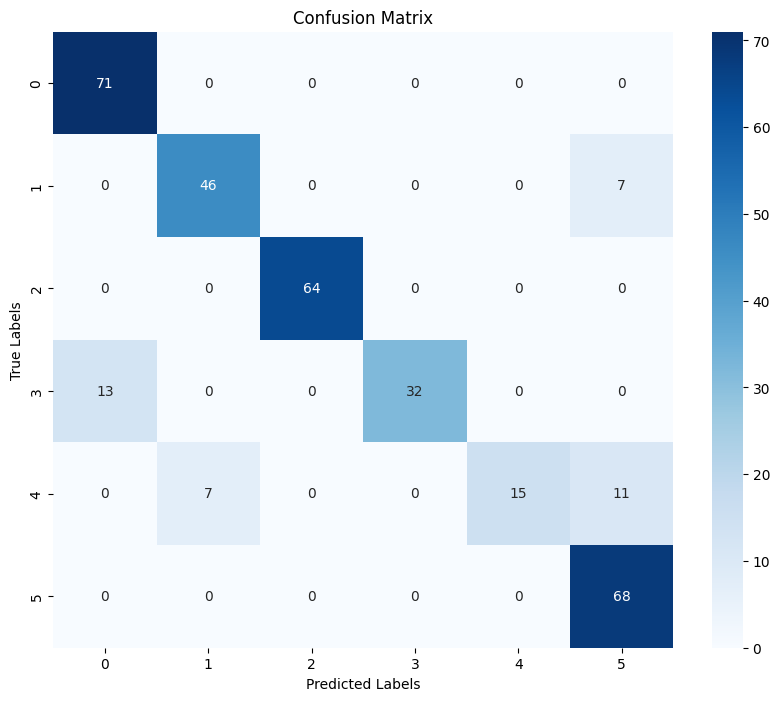

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming 'test_loader' is your DataLoader for the test set
all_preds = []
all_labels = []

#TESTING
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for inference
    for images, labels in test_loader:
        outputs = model(images)  # Forward pass to get the outputs
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        all_labels.extend(labels.cpu().numpy())  # Collect true labels

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Assuming `all_labels` and `all_preds` are lists or tensors containing true labels and predicted labels
# Convert them to NumPy arrays if needed
if isinstance(all_labels[0], torch.Tensor):
    all_labels = torch.cat(all_labels).cpu().numpy()  # Concatenate if they are tensors
if isinstance(all_preds[0], torch.Tensor):
    all_preds = torch.cat(all_preds).cpu().numpy()  # Concatenate if they are tensors

# If all_labels and all_preds are not already arrays, convert them
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision, recall, and F1-score using classification_report
# You can specify target_names if you want custom class names
num_classes = len(np.unique(all_labels))  # Unique number of classes from the labels

# Generate the classification report for all classes
report = classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(num_classes)], digits=4)

print('Overall Classification Report:')
print(report)

Accuracy: 0.89
Overall Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8452    1.0000    0.9161        71
     Class 1     0.8679    0.8679    0.8679        53
     Class 2     1.0000    1.0000    1.0000        64
     Class 3     1.0000    0.7111    0.8312        45
     Class 4     1.0000    0.4545    0.6250        33
     Class 5     0.7907    1.0000    0.8831        68

    accuracy                         0.8862       334
   macro avg     0.9173    0.8389    0.8539       334
weighted avg     0.9035    0.8862    0.8776       334

